<a href="https://colab.research.google.com/github/CorentinMAG/NLP/blob/main/Assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 4

**Due to**: TBD

**Credits**: Andrea Galassi, Federico Ruggeri, Paolo Torroni

**Summary**: Fact checking, Neural Languange Inference (**NLI**)

# Intro

This assignment is centred on a particular and emerging NLP task, formally known as **fact checking** (or fake checking). As AI techniques become more and more powerful, reaching amazing results, such as image and text generation, it is more than ever necessary to build tools able to distinguish what is real from what is fake.

Here we focus on a small portion of the whole fact checking problem, which aims to determine whether a given statement (fact) conveys a trustworthy information or not. 

More precisely, given a set of evidences and a fact to verify, we would like our model to correctly predict whether the fact is true or fake.

In particular, we will see:

*   Dataset preparation (analysis and pre-processing)
*   Problem formulation: multi-input binary classification
*   Defining an evaluation method
*   Simple sentence embedding
*   Neural building blocks
*   Neural architecture extension

# The FEVER dataset

First of all, we need to choose a dataset. In this assignment we will rely on the [FEVER dataset](https://fever.ai).

The dataset is about facts taken from Wikipedia documents that have to be verified. In particular, facts could face manual modifications in order to define fake information or to give different formulations of the same concept.

The dataset consists of 185,445 claims manually verified against the introductory sections of Wikipedia pages and classified as ```Supported```, ```Refuted``` or ```NotEnoughInfo```. For the first two classes, systems and annotators need to also return the combination of sentences forming the necessary evidence supporting or refuting the claim.

## Dataset structure

Relevant data is divided into two file types. Information concerning the fact to verify, its verdict and associated supporting/opposing statements are stored in **.jsonl** format. In particular, each JSON element is a python dictionary with the following relevant fields:

*    **ID**: ID associated to the fact to verify.

*    **Verifiable**: whether the fact has been verified or not: ```VERIFIABLE``` or ```NOT VERIFIABLE```.
    
*    **Label**: the final verdict on the fact to verify: ```SUPPORTS```, ```REFUTES``` or ```NOT ENOUGH INFO```.
    
*    **Claim**: the fact to verify.
    
*    **Evidence**: a nested list of document IDs along with the sentence ID that is associated to the fact to verify. In particular, each list element is a tuple of four elements: the first two are internal annotator IDs that can be safely ignored; the third term is the document ID (called URL) and the last one is the sentence number (ID) in the pointed document to consider.

**Some Examples**

---

**Verifiable**

{"id": 202314, "verifiable": "VERIFIABLE", "label": "REFUTES", "claim": "The New Jersey Turnpike has zero shoulders.", "evidence": [[[238335, 240393, "New_Jersey_Turnpike", 15]]]}

---

**Not Verifiable**

{"id": 113501, "verifiable": "NOT VERIFIABLE", "label": "NOT ENOUGH INFO", "claim": "Grease had bad reviews.", "evidence": [[[133128, null, null, null]]]}

---

## Some simplifications and pre-processing

We are only interested in verifiable facts. Thus, we can filter out all non-verifiable claims.

Additionally, the current dataset format does not contain all necessary information for our classification purposes. In particular, we need to download Wikipedia documents and replace reported evidence IDs with the corresponding text.

Don't worry about that! We are providing you the already pre-processed dataset so that you can concentrate on the classification pipeline (pre-processing, model definition, evaluation and training).

You can download the zip file containing all set splits (train, validation and test) of the FEVER dataset by clicking on this [link](https://drive.google.com/file/d/1wArZhF9_SHW17WKNGeLmX-QTYw9Zscl1/view?usp=sharing). Alternatively, run the below code cell to automatically download it on this notebook.

**Note**: each dataset split is in .csv format. Feel free to inspect the whole dataset!

In [ ]:
import os
import requests
import zipfile

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

def download_data(data_path):
    toy_data_path = os.path.join(data_path, 'fever_data.zip')
    toy_data_url_id = "1wArZhF9_SHW17WKNGeLmX-QTYw9Zscl1"
    toy_url = "https://docs.google.com/uc?export=download"

    if not os.path.exists(data_path):
        os.makedirs(data_path)

    if not os.path.exists(toy_data_path):
        print("Downloading FEVER data splits...")
        with requests.Session() as current_session:
            response = current_session.get(toy_url,
                                   params={'id': toy_data_url_id},
                                   stream=True)
        save_response_content(response, toy_data_path)
        print("Download completed!")

        print("Extracting dataset...")
        with zipfile.ZipFile(toy_data_path) as loaded_zip:
            loaded_zip.extractall(data_path)
        print("Extraction completed!")

download_data('dataset')

Download completed!
Extracting dataset...
Extraction completed!


In [ ]:
# usefuls import
import pandas as pd
import re
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
import nltk
import collections
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
import numpy as np
from string import ascii_letters, digits, whitespace,punctuation
nltk.download('stopwords')
from nltk.corpus import stopwords
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from collections import namedtuple
from copy import deepcopy
import gensim
import gensim.downloader as gloader
from keras.models import Sequential,Model
from keras.layers import Dense, Embedding, LSTM, Bidirectional, Dropout,Flatten,Input,Average,Add,Concatenate
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix,f1_score
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
Mounted at /content/drive


In [ ]:
tr_df = pd.read_csv('./dataset/train_pairs.csv',usecols=['Claim','Evidence','ID','Label'])
vl_df = pd.read_csv('./dataset/val_pairs.csv',usecols=['Claim','Evidence','ID','Label'])
ts_df = pd.read_csv('./dataset/test_pairs.csv',usecols=['Claim','Evidence','ID','Label'])
tr_df.head()

,Claim,Evidence,ID,Label
0,Chris Hemsworth appeared in A Perfect Getaway.,2\tHemsworth has also appeared in the science ...,3,SUPPORTS
1,Roald Dahl is a writer.,0\tRoald Dahl -LRB- -LSB- langpronˈroʊ.əld _ ˈ...,7,SUPPORTS
2,Roald Dahl is a governor.,0\tRoald Dahl -LRB- -LSB- langpronˈroʊ.əld _ ˈ...,8,REFUTES
3,Ireland has relatively low-lying mountains.,10\tThe island 's geography comprises relative...,9,SUPPORTS
4,Ireland does not have relatively low-lying mou...,10\tThe island 's geography comprises relative...,10,REFUTES


Obviously, the dataset needs some preprocessing.  
We will:
* lower case each sentence
* get rid of specials and non alphanumeric tokens in the Evidence sequence
* get rid of the number at the beginning of each evidence
* stem each sentence

But first, let's look at the dataset

 samples : 121740


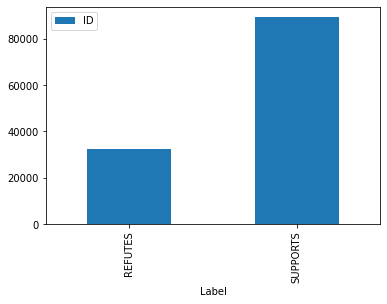

In [ ]:
tr_df.drop(labels=['Claim','Evidence'],axis=1).groupby(['Label']).count().plot.bar()
print(f" samples : {tr_df.shape[0]}")

**The SUPPORTS class is more represented than the REFUTES class in the training dataset.**   
Classes are imbalanced. That could be a problem when we will train and analyse our model.

 samples : 7165


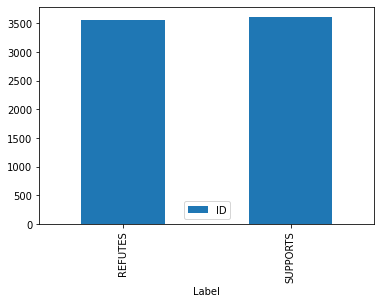

In [ ]:
vl_df.drop(labels=['Claim','Evidence'],axis=1).groupby(['Label']).count().plot.bar()
print(f" samples : {vl_df.shape[0]}")

The validation dataset is more balanced. 

In [ ]:
tr_df.iloc[1]['Evidence']

'0\tRoald Dahl -LRB- -LSB- langpronˈroʊ.əld _ ˈdɑːl -RSB- , -LSB- ˈɾuːɑl dɑl -RSB- ; 13 September 1916 -- 23 November 1990 -RRB- was a British novelist , short story writer , poet , screenwriter , and fighter pilot .\tfighter pilot\tfighter pilot'

The text obviously needs some preprocessing 

In [ ]:
def count_word(df):
  counts = []
  for col in ['Evidence','Claim']:
    count = df[col].str.split().str.len()
    count.index = count.index.astype(str) + ' words:'
    count.sort_index(inplace=True)
    counts.append(count)
  return counts

In [ ]:
tr_counts = count_word(tr_df)
vl_counts = count_word(vl_df)

count    121740.000000
mean         48.197585
std          25.980218
min           2.000000
25%          30.000000
50%          43.000000
75%          59.000000
max         237.000000
Name: Evidence, dtype: float64

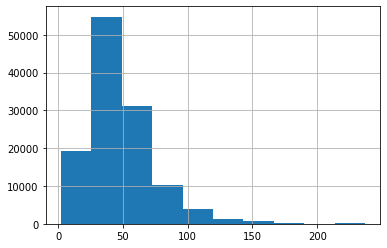

In [ ]:
# Evidence
tr_counts[0].hist()
tr_counts[0].describe()

As we can see, the longest evidence in the training set contains 237 words 

count    121740.000000
mean          8.220174
std           3.317578
min           2.000000
25%           6.000000
50%           8.000000
75%          10.000000
max          65.000000
Name: Claim, dtype: float64

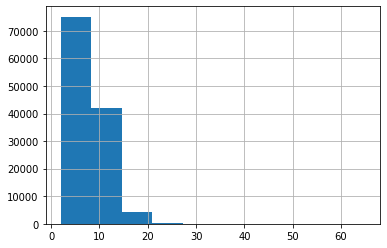

In [ ]:
tr_counts[1].hist()
tr_counts[1].describe()

The longest claim contains 64 words

In [ ]:
print(f"the whole training set contains {tr_counts[0].sum()+tr_counts[1].sum()} words")

the whole training set contains 6868298 words


count    7165.000000
mean       42.116539
std        20.759429
min         8.000000
25%        27.000000
50%        37.000000
75%        52.000000
max       208.000000
Name: Evidence, dtype: float64

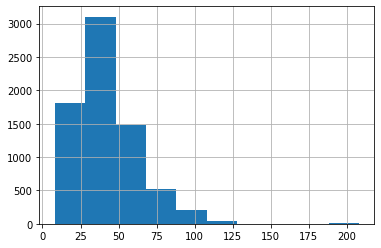

In [ ]:
vl_counts[0].hist()
vl_counts[0].describe()

count    7165.000000
mean        8.230286
std         2.973830
min         2.000000
25%         6.000000
50%         8.000000
75%        10.000000
max        31.000000
Name: Claim, dtype: float64

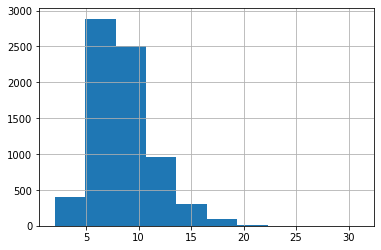

In [ ]:
vl_counts[1].hist()
vl_counts[1].describe()

In [ ]:
print(f"the whole validation set contains {vl_counts[0].sum()+vl_counts[1].sum()} words")

the whole validation set contains 360735 words


OK in this part we have seen that sentences in our datasets aren't very long.  
We have a sentence in the training set which has only 2 words.  
We need to take care of that when we will preprocess the text.

Ok now we know that maybe the training set isn't great, we can preprocess the text.

# Classification dataset

At this point, you should have a reay-to-go dataset! Note that the dataset format changed as well! In particular, we split the evidence set associated to each claim, in order to build (claim, evidence) pairs. The classification label is propagated as well.

We'll motivate this decision in the next section!

Just for clarity, here's an example of the pre-processed dataset:

---

**Claim**: "Wentworth Miller is yet to make his screenwriting debut."

**Evidence**: "2	He made his screenwriting debut with the 2013 thriller film Stoker .	Stoker	Stoker (film)"

**Label**: Refutes

---

**Note**: The dataset requires some text cleaning as you may notice!


In [ ]:
def allowed_char(text):
  allowed_char = ascii_letters + digits + whitespace + punctuation
  return "".join([c for c in text if c in allowed_char])

def remove_tokens(text):
  regex = '(-[a-zA-Z]+-)'
  return re.sub(regex,'',text)

def remove_last_sentence(text):
  return text.split('\t')[1]

def to_lower(text):
  return text.lower()

def remove_stopwords(text):
    stopwords_list = stopwords.words('english')
    whitelist = ["n't",'no','not','none','nobody','nothing','neither','nowhere','never',
                 "doesn't","isn't","wasn't","shouldn't","wouldn't","couldn't","won't","can't","don't"]
    words = text.split() 
    clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
    return " ".join(clean_words) 

def stem(text):
  porter = PorterStemmer()
  words = text.split() 
  stemmed_words = [porter.stem(word) for word in words]
  return " ".join(stemmed_words)

def remove_punctuation(text):
  # Make translation table
  trantab = str.maketrans(punctuation, len(punctuation)*' ')  # Every punctuation symbol will be replaced by a space
  return text.translate(trantab)

def preprocess_pipeline(text,remove=False):
  if remove:
    text = remove_last_sentence(text)
  text = allowed_char(text)
  text = remove_tokens(text)
  text = to_lower(text)
  text = remove_punctuation(text)
  text = remove_stopwords(text)
  #text = stem(text)
  return text.strip()

def clean_df(df):
  df = df
  cols = ["Claim","Evidence"]
  c_col = df['Claim'].apply(preprocess_pipeline)
  e_col = df['Evidence'].apply(lambda x:preprocess_pipeline(x,True))
  df['Claim'] = c_col
  df['Evidence'] = e_col
  return df

In [ ]:
tr_df = clean_df(tr_df)
ts_df_ = clean_df(ts_df)
vl_df = clean_df(vl_df)

In [ ]:
tr_df.head()

,Claim,Evidence,ID,Label
0,chris hemsworth appeared perfect getaway,hemsworth also appeared science fiction action...,3,SUPPORTS
1,roald dahl writer,roald dahl langpronro ld dl ul dl 13 september...,7,SUPPORTS
2,roald dahl governor,roald dahl langpronro ld dl ul dl 13 september...,8,REFUTES
3,ireland relatively low lying mountains,island geography comprises relatively low lyin...,9,SUPPORTS
4,ireland not relatively low lying mountains,island geography comprises relatively low lyin...,10,REFUTES


In [ ]:
vl_df.head()

,Claim,Evidence,ID,Label
0,indian army comprises part country active defe...,volunteer force comprises 80 country active de...,98304,SUPPORTS
1,recovery features rihanna,eminem also collaborated artists pink lil wayn...,98305,SUPPORTS
2,rihanna recovery,eminem also collaborated artists pink lil wayn...,98306,SUPPORTS
3,philomena nominated,film nominated four categories 86th academy aw...,27307,SUPPORTS
4,vietnam mascot,vietnam vt nm officially socialist republic vi...,98312,REFUTES


We can recheck our distribution of words,  
but before, as we said, there are maybe samples with no claim at all and we need to handle that.

In [ ]:
np.where(tr_df.applymap(lambda x: x == ''))

(array([], dtype=int64), array([], dtype=int64))

In [ ]:
np.where(ts_df.applymap(lambda x: x == ''))

(array([], dtype=int64), array([], dtype=int64))

In [ ]:
np.where(vl_df.applymap(lambda x: x == ''))

(array([], dtype=int64), array([], dtype=int64))

It's fine, all samples have still a claim

In [ ]:
tr_counts = count_word(tr_df)
vl_counts = count_word(vl_df)
ts_counts = count_word(ts_df)

count    121740.000000
mean         17.245655
std           7.883754
min           1.000000
25%          12.000000
50%          16.000000
75%          21.000000
max          90.000000
Name: Evidence, dtype: float64

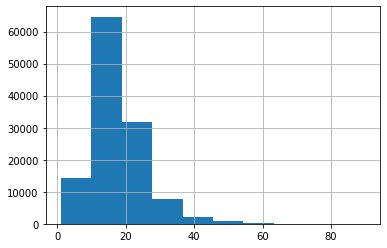

In [ ]:
tr_counts[0].hist()
tr_counts[0].describe()

We can see that our sentences are shorter because we removed the last one (because for lots of evidences it was just a redundant sentence )

count    121740.000000
mean          5.391359
std           2.243954
min           1.000000
25%           4.000000
50%           5.000000
75%           6.000000
max          56.000000
Name: Claim, dtype: float64

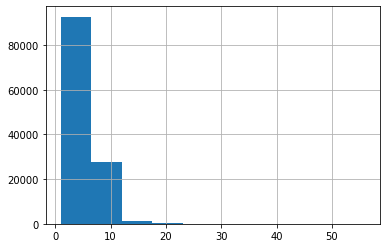

In [ ]:
tr_counts[1].hist()
tr_counts[1].describe()

In [ ]:
print(f"the whole training set contains {tr_counts[0].sum()+tr_counts[1].sum()} words")

the whole training set contains 2755830 words


count    7165.000000
mean       15.666574
std         7.057023
min         2.000000
25%        11.000000
50%        14.000000
75%        19.000000
max        77.000000
Name: Evidence, dtype: float64

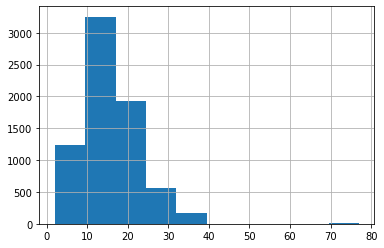

In [ ]:
vl_counts[0].hist()
vl_counts[0].describe()

count    7165.000000
mean        5.316399
std         1.947157
min         2.000000
25%         4.000000
50%         5.000000
75%         6.000000
max        21.000000
Name: Claim, dtype: float64

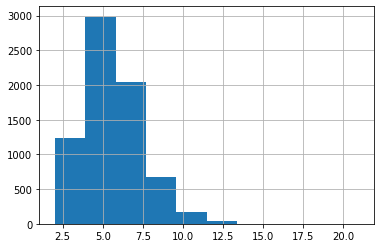

In [ ]:
vl_counts[1].hist()
vl_counts[1].describe()

In [ ]:
print(f"the whole validation set contains {vl_counts[0].sum()+vl_counts[1].sum()} words")

the whole validation set contains 150343 words


## Summary

|           |        | before preprocessing | after preprocessing |
|-----------|--------|----------------------|---------------------|
|**training**   | samples|      121 740       |     121 740       |
|           | tot. nb. words|     6 868 298 |     2 755 830    |
|           | avg. words per claim|    8    |        5|
|           | **max. words per claim**|    65    |       **56**|
|           | avg. words per evidence|  48   |       17              |
|           | **max. words per evidence**|    237    |       **90**|
|           | avg. nb. sentences per claim| 1 |     1                |
|           | avg. nb. sentences per evidence | 2  |  1                |
|           |  REFUTES<br>SUPPORTS |  32 351 <br/> 89 389  | 32 351 <br> 89 389 |
|-----------|---------------------------------------|----------------------|---------------------|
|**validation**   | samples|      7 165       |     7 165       |
|           | tot. nb. words|     367 742 |     150 343    |
|           | avg. words per claim|    9    |        5|
|           | **max. words per claim**|    31    |       **21**|
|           | avg. words per evidence|  43   |       16              |
|           | **max. words per evidence**|    208    |       **77**|
|           | avg. nb. sentences per claim| 1 |     1                |
|           | avg. nb. sentences per evidence | 2  |  1                |
|           |  REFUTES<br>SUPPORTS |  3 554 <br/> 3 611  | 3 554 <br/> 3 611 |



# Problem formulation

As mentioned at the beginning of the assignment, we are going to formulate the fact checking problem as a binary classification task.

In particular, each dataset sample is comprised of:

*     A claim to verify
*     A set of semantically related statements (evidence set)
*     Fact checking label: either evidences support or refute the claim.

Handling the evidence set from the point of view of neural models may imply some additional complexity: if the evidence set is comprised of several sentences we might incur in memory problems.

To this end, we further simplify the problem by building (claim, evidence) pairs. The fact checking label is propagated as well.

Example:

     Claim: c1 
     Evidence set: [e1, e2, e3]
     Label: S (support)

--->

    (c1, e1, S),
    (c1, e2, S),
    (c1, e3, S)

## Schema

The overall binary classification problem is summed up by the following (simplified) schema

![](https://drive.google.com/uc?export=view&id=1Wm_YBnFwgJtxcWEBpPbTBEVkpKaL08Jp)

Don't worry too much about the **Encoding** block for now. We'll give you some simple guidelines about its definition. For the moment, stick to the binary classification task definition where, in this case, we have 2 inputs: the claim to verify and one of its associated evidences.

# Architecture Guidelines

There are many neural architectures that follow the above schema. To avoid phenomena like the writer's block, in this section we are going to give you some implementation guidelines.

In particular, we would like you to test some implementations so that you explore basic approaches (neural baselines) and use them as building blocks for possible extensions.

## Handling multiple inputs

The first thing to notice is that we are in a multi-input scenario. In particular, each sample is comprised of a fact and its asssociated evidence statement.

Each of these input is encoded as a sequence of tokens. In particular, we will have the following input matrices:

*    Claim: [batch_size, max_tokens]
*    Evidence: [batch_size, max_tokens]

Moreover, after the embedding layer, we'll have:

*    Claim: [batch_size, max_tokens, embedding_dim]
*    Evidence: [batch_size, max_tokens, embedding_dim]

But, we would like to have a 2D input to our classifier, since we have to give an answer at pair level. Therefore, for each sample, we would expect the following input shape to our classification block:

*   Classification input shape: [batch_size, dim]

**How to do that?**

We inherently need to reduce the token sequence to a single representation. This operation is formally known as **sentence embedding**. Indeed, we are trying to compress the information of a whole sequence into a single embedding vector.

Here are some simple solutions that we ask you to try out:

*   Encode token sequences via a RNN and take the last state as the sentence embedding.

*   Encode token sequences via a RNN and average all the output states.

*   Encode token sequences via a simple MLP layer. In particular, if your input is a [batch_size, max_tokens, embedding_dim] tensor, the matrix multiplication works on the **max_tokens** dimension, resulting in a [batch_size, embedding_dim] 2D matrix.

*   Compute the sentence embedding as the mean of its token embeddings (**bag of vectors**).

# Vocabulary and tokenization

The Glove embedding will be our bare vocabulary, we will add sequentially words from the training, validation and test set, as done in the previous assignment.  

**NOTE :** In a real case scenario, we surely wouldn't do that. Indeed, the real steps are:
1. Starting vocabulary V1 (in this assignment, GloVe vocabulary)
2. Compute embeddings for terms out of vocabulary V1 (OOV1) of the training split 
3. Add embeddings to the vocabulary, so to obtain vocabulary V2
4. Training of the model(s)
5. Compute embeddings for terms OOV2 of the validation split 
6. Add embeddings to the vocabulary, so to obtain vocabulary V3
7. Validation of the model(s)
8. Compute embeddings for terms OOV3 of the test split 
9. Add embeddings to the vocabulary, so to obtain vocabulary V4
10. Testing of the final model 


In [ ]:
EMBEDDING_SIZE = 300
MAX_LEN = 100

In [ ]:
def download_glove_embedding(embedding_dimension=50):
  download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)
  try:
    emb_model = gloader.load(download_path)
  except ValueError as e:
      print("Glove: 50, 100, 200, 300")
      raise e
  return emb_model

In [ ]:
glove_model = download_glove_embedding(EMBEDDING_SIZE)

[==================================================] 100.0% 376.1/376.1MB downloaded


In [ ]:
vocab = deepcopy(glove_model.vocab)

In [ ]:
print(f" vocab length : {len(vocab)} words")

 vocab length : 400000 words


In [ ]:
def update_vocab(vocab,new_vocab):
  vocab.update(new_vocab)

In [ ]:
def compute_oov_embedding(vocabulary,df):
  oov = {}
  vocab_evidence = set(pd.Series([x for _list in df['Evidence'].apply(lambda x:x.split()) for x in _list]))
  vocab_claim = set(pd.Series([x for _list in df['Claim'].apply(lambda x:x.split()) for x in _list]))
  vocab = vocab_evidence.union(vocab_claim)
  for w in vocab:
    if w not in vocabulary:
      oov[w] = np.random.randn(1,EMBEDDING_SIZE) # we handle oov words by computing a random embedding
  return oov

In [ ]:
training_oov = compute_oov_embedding(vocab,tr_df) # we compute embedding for oov in the training dataset
update_vocab(vocab,training_oov) # we update the vocabulary with new embeddings
validation_oov = compute_oov_embedding(vocab,vl_df)
update_vocab(vocab,validation_oov)
testing_oov = compute_oov_embedding(vocab,ts_df)
update_vocab(vocab,testing_oov)

In [ ]:
print(f" size of the final vocabulary : {len(vocab)}")

 size of the final vocabulary : 403859


In [ ]:
def adapt_vocab(vocab):
  word_list = ["PAD"] # we add the PAD token
  for w in vocab:
    word_list.append(w)
  idx_to_word = pd.Series(word_list,index = [i for i in range(len(word_list))])
  idx_to_word = idx_to_word.to_dict()
  word_to_idx = pd.Series(data = [x for x in range(len(idx_to_word))],index=word_list).to_dict()
  return word_list,idx_to_word,word_to_idx

In [ ]:
word_list,idx_to_word,word_to_idx = adapt_vocab(vocab)

In [ ]:
VOCAB_SIZE = len(word_list)

In [ ]:
def create_embedding_matrix(model,vocab,word_list,idx_to_word,word_to_idx):
  v = len(word_list)
  embedding_matrix = np.zeros((v,EMBEDDING_SIZE))
  for w,i in word_to_idx.items():
    if w == 'PAD': 
      embedding_matrix[i] = np.zeros((1,EMBEDDING_SIZE))
    elif w in model.vocab:
      embedding_matrix[i] = model.get_vector(w)
    else:
      embedding_matrix[i] = vocab[w]
  return embedding_matrix

In [ ]:
embedding_matrix = create_embedding_matrix(glove_model,vocab,word_list,idx_to_word,word_to_idx)

In [ ]:
embedding_matrix.shape

(403860, 300)

In [ ]:
def tokenization(seq,word_to_idx):
    return np.array([word_to_idx[x] for x in seq])

In [ ]:
tr_df['evidence_encoded'] = tr_df['Evidence'].apply(lambda x:x.split()).apply(lambda x:tokenization(x,word_to_idx))
tr_df['claim_encoded'] = tr_df['Claim'].apply(lambda x:x.split()).apply(lambda x:tokenization(x,word_to_idx))

# and we do the same for the validation set
vl_df['evidence_encoded'] = vl_df['Evidence'].apply(lambda x:x.split()).apply(lambda x:tokenization(x,word_to_idx))
vl_df['claim_encoded'] = vl_df['Claim'].apply(lambda x:x.split()).apply(lambda x:tokenization(x,word_to_idx))

# and for the test dataset
ts_df['evidence_encoded'] = ts_df['Evidence'].apply(lambda x:x.split()).apply(lambda x:tokenization(x,word_to_idx))
ts_df['claim_encoded'] = ts_df['Claim'].apply(lambda x:x.split()).apply(lambda x:tokenization(x,word_to_idx))

In [ ]:
tr_df['label_encoded'] = tr_df['Label'].map({'SUPPORTS':1, 'REFUTES':0})
vl_df['label_encoded'] = vl_df['Label'].map({'SUPPORTS':1, 'REFUTES':0})
ts_df['label_encoded'] = ts_df['Label'].map({'SUPPORTS':1, 'REFUTES':0})

In [ ]:
tr_df.head()

,Claim,Evidence,ID,Label,evidence_encoded,claim_encoded,label_encoded
0,chris hemsworth appeared perfect getaway,hemsworth also appeared science fiction action...,3,SUPPORTS,"[107954, 53, 790, 1122, 3955, 609, 320, 754, 9...","[2103, 107954, 790, 2616, 20647]",1
1,roald dahl writer,roald dahl langpronro ld dl ul dl 13 september...,7,SUPPORTS,"[53403, 21758, 400126, 6696, 20835, 13322, 208...","[53403, 21758, 1542]",1
2,roald dahl governor,roald dahl langpronro ld dl ul dl 13 september...,8,REFUTES,"[53403, 21758, 400126, 6696, 20835, 13322, 208...","[53403, 21758, 1005]",0
3,ireland relatively low lying mountains,island geography comprises relatively low lyin...,9,SUPPORTS,"[584, 4214, 7817, 2224, 654, 4740, 2755, 2724,...","[1323, 2224, 654, 4740, 2755]",1
4,ireland not relatively low lying mountains,island geography comprises relatively low lyin...,10,REFUTES,"[584, 4214, 7817, 2224, 654, 4740, 2755, 2724,...","[1323, 37, 2224, 654, 4740, 2755]",0


In [ ]:
def add_padding(seq,pad_token,pad_length):
    if seq.shape[0] < pad_length:
        while seq.shape[0] < pad_length:
            seq = np.append(seq,pad_token)
        return np.expand_dims(seq,axis=0) 
    elif seq.shape[0] > pad_length:
        while seq.shape[0] > pad_length:
            seq = np.delete(seq,-1)
        return np.expand_dims(seq,axis=0) 
    else:
        return np.expand_dims(seq,axis=0)

def concatenate(x):
  return np.concatenate(x.values)

In [ ]:
tr_df['evidence_encoded_pad'] = tr_df['evidence_encoded'].apply(lambda x:add_padding(x,0,MAX_LEN))
tr_df['claim_encoded_pad'] = tr_df['claim_encoded'].apply(lambda x:add_padding(x,0,MAX_LEN))

vl_df['evidence_encoded_pad'] = vl_df['evidence_encoded'].apply(lambda x:add_padding(x,0,MAX_LEN))
vl_df['claim_encoded_pad'] = vl_df['claim_encoded'].apply(lambda x:add_padding(x,0,MAX_LEN))

ts_df['evidence_encoded_pad'] = ts_df['evidence_encoded'].apply(lambda x:add_padding(x,0,MAX_LEN))
ts_df['claim_encoded_pad'] = ts_df['claim_encoded'].apply(lambda x:add_padding(x,0,MAX_LEN))

In [ ]:
tr_df.head()

,Claim,Evidence,ID,Label,evidence_encoded,claim_encoded,label_encoded,evidence_encoded_pad,claim_encoded_pad
0,chris hemsworth appeared perfect getaway,hemsworth also appeared science fiction action...,3,SUPPORTS,"[107954, 53, 790, 1122, 3955, 609, 320, 754, 9...","[2103, 107954, 790, 2616, 20647]",1,"[[107954, 53, 790, 1122, 3955, 609, 320, 754, ...","[[2103, 107954, 790, 2616, 20647, 0, 0, 0, 0, ..."
1,roald dahl writer,roald dahl langpronro ld dl ul dl 13 september...,7,SUPPORTS,"[53403, 21758, 400126, 6696, 20835, 13322, 208...","[53403, 21758, 1542]",1,"[[53403, 21758, 400126, 6696, 20835, 13322, 20...","[[53403, 21758, 1542, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,roald dahl governor,roald dahl langpronro ld dl ul dl 13 september...,8,REFUTES,"[53403, 21758, 400126, 6696, 20835, 13322, 208...","[53403, 21758, 1005]",0,"[[53403, 21758, 400126, 6696, 20835, 13322, 20...","[[53403, 21758, 1005, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,ireland relatively low lying mountains,island geography comprises relatively low lyin...,9,SUPPORTS,"[584, 4214, 7817, 2224, 654, 4740, 2755, 2724,...","[1323, 2224, 654, 4740, 2755]",1,"[[584, 4214, 7817, 2224, 654, 4740, 2755, 2724...","[[1323, 2224, 654, 4740, 2755, 0, 0, 0, 0, 0, ..."
4,ireland not relatively low lying mountains,island geography comprises relatively low lyin...,10,REFUTES,"[584, 4214, 7817, 2224, 654, 4740, 2755, 2724,...","[1323, 37, 2224, 654, 4740, 2755]",0,"[[584, 4214, 7817, 2224, 654, 4740, 2755, 2724...","[[1323, 37, 2224, 654, 4740, 2755, 0, 0, 0, 0,..."


## Merging multi-inputs

At this point, we have to think about **how** we should merge evidence and claim sentence embeddings.

For simplicity, we stick to simple merging strategies:

*     **Concatenation**: define the classification input as the concatenation of evidence and claim sentence embeddings

*     **Sum**: define the classification input as the sum of evidence and claim sentence embeddings

*     **Mean**: define the classification input as the mean of evidence and claim sentence embeddings

For clarity, if we the sentence embedding of a single input has shape [batch_size, embedding_dim], then the classification input has shape:

*     **Concatenation**: [batch_size, 2 * embedding_dim]

*     **Sum**: [batch_size, embedding_dim]

*     **Mean**: [batch_size, embedding_dim]

# A simple extension

Lastly, we ask you to modify previously defined neural architectures by adding an additional feature to the classification input.

We would like to see if some similarity information between the claim to verify and one of its associated evidence might be useful to the classification.

Compute the cosine similarity metric between the two sentence embeddings and concatenate the result to the classification input.

For clarity, since the cosine similarity of two vectors outputs a scalar value, the classification input shape is modified as follows:

*     **Concatenation**: [batch_size, 2 * embedding_dim + 1]

*     **Sum**: [batch_size, embedding_dim + 1]

*     **Mean**: [batch_size, embedding_dim + 1]



In [ ]:
# model
def classifier( embedding_matrix, encode_mode = 'bag_of_vectors', hidden_units = [128], merge_mode = 'concat',
               dropout = False, dropout_prob = 0.5, return_sequences = False,cosine = False,label_smoothing=0):
  
  """
  encode_mode: string - LSTM, MLP or bag_of_vectors
  embedding_matrix: np.ndarray (vocab_size,EMBEDDING_SIZE)
  hidden_units: list of int - nb. of dense layer with hidden_units
  merge_mode: concat or avg
  dropout: wether to add a dropout layer
  dropout_prob: int
  return_sequence: boolean - wether return all hidden state of the LSTM or not-
  cosine: boolean -wether to feed cosine similarity between claim and evidence to the classifier or not-
  """
  
  # inputs
  input_sequence_evidence = Input(shape = (MAX_LEN,))
  input_sequence_claim = Input(shape = (MAX_LEN,))
  input_sequences = [input_sequence_evidence, input_sequence_claim]

  embedding_layer = Embedding(
                              input_dim = VOCAB_SIZE,
                              output_dim = EMBEDDING_SIZE,
                              input_length = MAX_LEN,
                              weights = [embedding_matrix],
                              mask_zero = True,
                              trainable = False
                              )
  
  encoded_sequences = []
  for input_sequence in input_sequences:
  
    # embeddings
    embedded_sequence = embedding_layer(input_sequence)

    # encoding sequences
    if encode_mode != 'bag_of_vectors': # LSTM / MLP cases

      if encode_mode == 'LSTM':
        encode_layer = Bidirectional(LSTM(units = EMBEDDING_SIZE, return_sequences = return_sequences,
                                return_state = False), merge_mode = 'concat') (embedded_sequence)

      elif encode_mode == 'MLP':
        flat = Flatten() (embedded_sequence) # each sentence will have (max_length*embedding_size) shape
        encode_layer = Dense(units = EMBEDDING_SIZE)(flat)

      encoded_sequence = encode_layer

      if return_sequences: # average of hidden states
        encoded_sequence = tf.math.reduce_mean(encoded_sequence,axis=1)
    
    else: # bag of vectors case
      encoded_sequence = tf.math.reduce_mean(embedded_sequence,axis=1)
    
    encoded_sequences.append(encoded_sequence)

  
  # merging
  if merge_mode == 'avg':
    dense_input = Average()([encoded_sequences[0], encoded_sequences[1]])

  elif merge_mode == 'concat':
    dense_input = Concatenate(axis=1)([encoded_sequences[0],encoded_sequences[1]])

  elif merge_mode == 'add':
    dense_input = Add()([encoded_sequences[0],encoded_sequences[1]])

  if cosine:

    cosine = tf.keras.losses.cosine_similarity(encoded_sequences[0],encoded_sequences[1],axis=1)
    cosine = tf.expand_dims(cosine,axis=1)

    dense_input = Concatenate(axis=1)([dense_input,cosine])

  # classifier
  for units in hidden_units:
    dense_input = Dense(units = units, activation = 'relu')(dense_input)

    if dropout:
      dense_input = Dropout(dropout_prob)(dense_input)

  output = Dense(1, activation = 'sigmoid')(dense_input)
  model = Model(inputs = [input_sequence_evidence, input_sequence_claim], outputs = output)
  loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=label_smoothing)
  model.compile(optimizer='adam', metrics = ['accuracy'], loss=loss)
  return model

In [ ]:
#training
X1_tr = concatenate(tr_df['evidence_encoded_pad'])
X2_tr = concatenate(tr_df['claim_encoded_pad'])
Y_tr = concatenate(tr_df['label_encoded'].apply(lambda x: np.expand_dims(x,axis=0)))

#validation
X1_vl = concatenate(vl_df['evidence_encoded_pad'])
X2_vl = concatenate(vl_df['claim_encoded_pad'])
Y_vl = concatenate(vl_df['label_encoded'].apply(lambda x: np.expand_dims(x,axis=0)))

#testing
X1_ts = concatenate(ts_df['evidence_encoded_pad'])
X2_ts = concatenate(ts_df['claim_encoded_pad'])
Y_ts = concatenate(ts_df['label_encoded'].apply(lambda x: np.expand_dims(x,axis=0)))

In [ ]:
def train_model(classifier,x,y,epochs=15,batch_size=32,validation_data=None,name=None):
  filepath = 'drive/MyDrive/weights_backups/{}/{}'.format(name,name)
  callback = tf.keras.callbacks.ModelCheckpoint(
      filepath= filepath,
      monitor='val_accuracy',
      save_weights_only=True,
      save_best_only=True
  )
  if validation_data != None:
    history = classifier.fit(x=x,
                             y=y,
                             epochs=epochs,
                             batch_size=batch_size,
                             validation_data=validation_data,
                             callbacks=[callback]
                             )
  else:
    history = classifier.fit(x=x,y=y,epochs=epochs,batch_size=batch_size,callbacks=[callback])
  history = history.history
  plt.plot(history['accuracy'])
  if validation_data != None:
    plt.plot(history['val_accuracy'])
    if name != None:
      plt.title('model accuracy {}'.format(name))
    else:
      plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc="lower right")
  else:
    if name != None:
      plt.title('model accuracy {}'.format(name))
    else:
      plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train'], loc="lower right")
  plt.show()

def load_weight(model,name):
  is_saved = False

  # we save weights on drive
  folder = 'drive/MyDrive/weights_backups/{}'.format(name)
  path_folder = os.path.join(os.getcwd(),folder)
  try:
    model.load_weights(os.path.join(path_folder,name))
    is_saved = True
  except:
    pass
  return is_saved

In [ ]:
lstm_last_state_concat = classifier(embedding_matrix,encode_mode='LSTM',dropout=True)
lstm_avg_state_concat = classifier(embedding_matrix,encode_mode='LSTM',dropout=True,return_sequences=True)
bag_of_vector_concat = classifier(embedding_matrix,dropout=True)
mlp_concat = classifier(embedding_matrix,dropout=True,encode_mode='MLP')

classifiers = [
               (lstm_last_state_concat,'lstm_last_state_concat'),
               (lstm_avg_state_concat,'lstm_avg_state_concat'),
               (bag_of_vector_concat,'bag_of_vector_concat'),
               (mlp_concat,'mlp_concat')]
               
for classifier in classifiers:
  cls,name = classifier
  if load_weight(cls,name) == False:
    train_model(cls,
                [X1_tr,X2_tr],
                Y_tr,
                epochs=15,
                batch_size=32,
                validation_data=([X1_vl,X2_vl],Y_vl),
                name=name
                )
    load_weight(cls,name)

In [ ]:
def print_result(classifier,x,y,name=None):
  prediction = classifier.predict(x)
  prediction = tf.round(prediction)
  prediction = tf.cast(prediction,dtype=tf.int32)
  print(f" result for {name} : ")
  print(f"F1-score : ",f1_score(y,prediction))
  print(classification_report(y,prediction))
  conf = confusion_matrix(y,prediction,labels=[0,1])
  print(conf)

In [ ]:
for classifier in classifiers:
  cls,name = classifier
  name+=' on the validation set'
  print_result(cls,[X1_vl,X2_vl],Y_vl,name=name)

 result for lstm_last_state_concat on the validation set : 
F1-score :  0.7581947743467934
              precision    recall  f1-score   support

           0       0.82      0.55      0.66      3554
           1       0.66      0.88      0.76      3611

    accuracy                           0.72      7165
   macro avg       0.74      0.71      0.71      7165
weighted avg       0.74      0.72      0.71      7165

[[1937 1617]
 [ 419 3192]]
 result for lstm_avg_state_concat on the validation set : 
F1-score :  0.758718190386428
              precision    recall  f1-score   support

           0       0.83      0.53      0.65      3554
           1       0.66      0.89      0.76      3611

    accuracy                           0.71      7165
   macro avg       0.74      0.71      0.70      7165
weighted avg       0.74      0.71      0.70      7165

[[1897 1657]
 [ 391 3220]]
 result for bag_of_vector_concat on the validation set : 
F1-score :  0.7155064610254273
              precision

In [ ]:
print_result(lstm_avg_state_concat,[X1_ts,X2_ts],Y_ts,name='lstm_avg_state_concat on the test set')

 result for lstm_avg_state_concat on the test set : 
F1-score :  0.7418234096082426
              precision    recall  f1-score   support

           0       0.79      0.54      0.64      3583
           1       0.65      0.86      0.74      3606

    accuracy                           0.70      7189
   macro avg       0.72      0.70      0.69      7189
weighted avg       0.72      0.70      0.69      7189

[[1938 1645]
 [ 510 3096]]


In [ ]:
lstm_avg_state_concat.evaluate(x=[X1_ts,X2_ts],y=Y_ts)

225/225 [==============================] - 2s 11ms/step - loss: 1.0662 - accuracy: 0.7002


[1.0661746263504028, 0.7002364993095398]

All models above have the same merging strategy, each time claim embedding is concatenated with the evidence embedding

<ins>Best model according to the f1-score on the validation set</ins> : **lstm_last_state_concat**


> merging strategy : **concatenation**



||F1-score validation set| F1-score test set
|--|-----------------------|------------------|
|**lstm_last_state_concat**|         75.8%             |-|
|**lstm_avg_state_concat**|       75.9%             |74.2%|
|**mlp_concat**|     71.6%                 |-|
|**bag_of_vectors_concat**|      71.1%            |-|


The best model so far is **lstm_avg_state_concat** so we will try others merging techniques on this model to see if we can get higher f1-score 

In [ ]:
lstm_avg_state_add = classifier(embedding_matrix,encode_mode='LSTM',dropout=True,merge_mode='add')
lstm_last_state_avg = classifier(embedding_matrix,encode_mode='LSTM',merge_mode='avg',dropout=True)

classifiers2 = [
                (lstm_last_state_add,'lstm_last_state_add'),
                (lstm_last_state_avg,'lstm_last_state_avg')
]
for classifier in classifiers2:
  cls,name = classifier
  if load_weight(cls,name) == False:
    train_model(cls,[X1_tr,X2_tr],Y_tr,validation_data=([X1_vl,X2_vl],Y_vl),name=name)
    load_weight(cls,name)

In [ ]:
for classifier in classifiers2:
  cls,name = classifier
  name+=' on the validation set'
  print_result(cls,[X1_vl,X2_vl],Y_vl,name=name)

 result for lstm_last_state_add on the validation set : 
F1-score :  0.7551167830483986
              precision    recall  f1-score   support

           0       0.81      0.56      0.66      3554
           1       0.67      0.87      0.76      3611

    accuracy                           0.72      7165
   macro avg       0.74      0.71      0.71      7165
weighted avg       0.74      0.72      0.71      7165

[[1995 1559]
 [ 475 3136]]
 result for lstm_last_state_avg on the validation set : 
F1-score :  0.7554479418886199
              precision    recall  f1-score   support

           0       0.80      0.57      0.67      3554
           1       0.67      0.86      0.76      3611

    accuracy                           0.72      7165
   macro avg       0.74      0.72      0.71      7165
weighted avg       0.74      0.72      0.71      7165

[[2025 1529]
 [ 491 3120]]


In [ ]:
print_result(lstm_last_state_avg,[X1_ts,X2_ts],Y_ts,name='lstm_last_state_avg on the test set')

 result for lstm_last_state_avg on the test set : 
F1-score :  0.7335168122532009
              precision    recall  f1-score   support

           0       0.78      0.53      0.63      3583
           1       0.65      0.85      0.73      3606

    accuracy                           0.69      7189
   macro avg       0.71      0.69      0.68      7189
weighted avg       0.71      0.69      0.68      7189

[[1897 1686]
 [ 541 3065]]


In [ ]:
lstm_last_state_avg.evaluate(x=[X1_ts,X2_ts],y=Y_ts)

225/225 [==============================] - 10s 10ms/step - loss: 1.7155 - accuracy: 0.6860


[1.715851068496704, 0.6902211904525757]

All merging strategies for the lstm_avg_state model

<ins>Best model according to the f1-score on the validation set</ins> : **lstm_last_state_avg**


||F1-score validation set| F1-score test set
|--|-----------------------|------------------|
|**lstm_last_state_concat**|         75.8%             |-|
|**lstm_last_state_add**|       75.5%             |-|
|**lstm_last_state_avg**|     75.6%                 |73.4%|


Now our best model so far is still **lstm_avg_state_concat**, we would like to know if the same model with cosine similarity could perform better.  
We will also try the lstm_last_state_concat with cosine similarity

Epoch 1/15
3805/3805 [==============================] - 118s 28ms/step - loss: 0.4891 - accuracy: 0.7887 - val_loss: 0.6553 - val_accuracy: 0.6669
Epoch 2/15
3805/3805 [==============================] - 104s 27ms/step - loss: 0.3873 - accuracy: 0.8348 - val_loss: 0.5812 - val_accuracy: 0.6911
Epoch 3/15
3805/3805 [==============================] - 101s 27ms/step - loss: 0.3147 - accuracy: 0.8614 - val_loss: 0.6127 - val_accuracy: 0.7082
Epoch 4/15
3805/3805 [==============================] - 101s 27ms/step - loss: 0.2447 - accuracy: 0.8897 - val_loss: 0.7382 - val_accuracy: 0.7052
Epoch 5/15
3805/3805 [==============================] - 99s 26ms/step - loss: 0.1876 - accuracy: 0.9134 - val_loss: 0.9060 - val_accuracy: 0.7126
Epoch 6/15
3805/3805 [==============================] - 99s 26ms/step - loss: 0.1492 - accuracy: 0.9318 - val_loss: 1.0858 - val_accuracy: 0.7034
Epoch 7/15
3805/3805 [==============================] - 98s 26ms/step - loss: 0.1259 - accuracy: 0.9444 - val_loss: 1.07

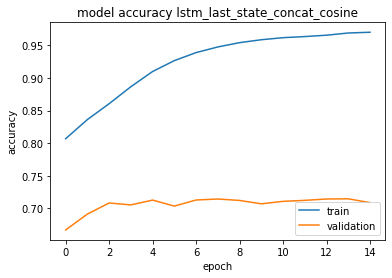

Epoch 1/15
3805/3805 [==============================] - 115s 27ms/step - loss: 0.4884 - accuracy: 0.7886 - val_loss: 0.6002 - val_accuracy: 0.6851
Epoch 2/15
3805/3805 [==============================] - 102s 27ms/step - loss: 0.3671 - accuracy: 0.8458 - val_loss: 0.5784 - val_accuracy: 0.7154
Epoch 3/15
3805/3805 [==============================] - 102s 27ms/step - loss: 0.2844 - accuracy: 0.8834 - val_loss: 0.6380 - val_accuracy: 0.7252
Epoch 4/15
3805/3805 [==============================] - 101s 27ms/step - loss: 0.2129 - accuracy: 0.9126 - val_loss: 0.6975 - val_accuracy: 0.7238
Epoch 5/15
3805/3805 [==============================] - 99s 26ms/step - loss: 0.1616 - accuracy: 0.9331 - val_loss: 0.7858 - val_accuracy: 0.7336
Epoch 6/15
3805/3805 [==============================] - 101s 26ms/step - loss: 0.1287 - accuracy: 0.9465 - val_loss: 0.9472 - val_accuracy: 0.7270
Epoch 7/15
3805/3805 [==============================] - 98s 26ms/step - loss: 0.1051 - accuracy: 0.9563 - val_loss: 1.0

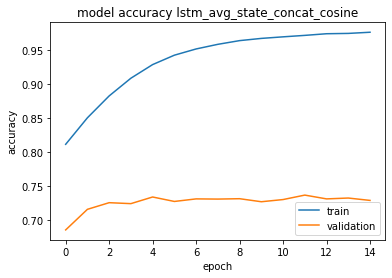

In [ ]:
lstm_last_state_concat_cosine = classifier(embedding_matrix,encode_mode='LSTM',merge_mode='concat',dropout=True,cosine=True)
lstm_avg_state_concat_cosine = classifier(embedding_matrix,encode_mode='LSTM',return_sequences=True,dropout=True,cosine=True)

classifiers3 = [
                (lstm_last_state_concat_cosine,'lstm_last_state_concat_cosine'),
                (lstm_avg_state_concat_cosine,'lstm_avg_state_concat_cosine')
]
for classifier in classifiers3:
  cls,name = classifier
  if load_weight(cls,name) == False:
    train_model(cls,[X1_tr,X2_tr],Y_tr,validation_data=([X1_vl,X2_vl],Y_vl),name=name)
    load_weight(cls,name)

In [ ]:
for classifier in classifiers3:
  cls,name = classifier
  name+=' on the validation set'
  print_result(cls,[X1_vl,X2_vl],Y_vl,name=name)

 result for lstm_last_state_concat_cosine on the validation set : 
F1-score :  0.75364413926033
              precision    recall  f1-score   support

           0       0.80      0.56      0.66      3554
           1       0.67      0.87      0.75      3611

    accuracy                           0.71      7165
   macro avg       0.74      0.71      0.71      7165
weighted avg       0.74      0.71      0.71      7165

[[1992 1562]
 [ 483 3128]]
 result for lstm_avg_state_concat_cosine on the validation set : 
F1-score :  0.7689861807508866
              precision    recall  f1-score   support

           0       0.82      0.60      0.69      3554
           1       0.69      0.87      0.77      3611

    accuracy                           0.74      7165
   macro avg       0.75      0.74      0.73      7165
weighted avg       0.75      0.74      0.73      7165

[[2132 1422]
 [ 467 3144]]


In [ ]:
print_result(lstm_avg_state_concat_cosine,[X1_ts,X2_ts],Y_ts,name='lstm_avg_state_concat_cosine on the test set')

 result for lstm_avg_state_concat_cosine on the test set : 
F1-score :  0.7595214843750001
              precision    recall  f1-score   support

           0       0.81      0.59      0.68      3583
           1       0.68      0.86      0.76      3606

    accuracy                           0.73      7189
   macro avg       0.74      0.73      0.72      7189
weighted avg       0.74      0.73      0.72      7189

[[2108 1475]
 [ 495 3111]]


<ins>Best model according to the f1-score on the validation set</ins> : **lstm_last_state_avg_concat_cosine**


||F1-score validation set| F1-score test set
|--|-----------------------|------------------|
|**lstm_last_state_concat_cosine**|         75.4%             |-|
|**lstm_avg_state_concat_cosine**|       76.9%             |76%|


## Summary

||F1-score validation set| F1-score test set
|--|-----------------------|------------------|
|**lstm_last_state_add**|       75.5%             |-|
|**lstm_last_state_avg**|     75.6%                 |73.4%|
|**lstm_last_state_concat**|         75.8%             |71.9%|
|**lstm_avg_state_concat**|       75.9%             |74.2%|
|**mlp_concat**|     71.1%                 |-|
|**bag_of_vectors_concat**|      71.6%            |-|
|**lstm_last_state_concat_cosine**|         75.4%             |-|
|**lstm_avg_state_concat_cosine**|       76.9%             |76%|

In [ ]:
def group_pair(df,name):
  return df.groupby('Claim')[name].apply(list) # each claim has 1 or multiple labels

def claim_verification(df,labels):
  group = group_pair(df,'label_encoded')
  y = group.apply(count)
  y = y.to_numpy()
  print(f" result for {name} : ")
  print(f"F1-score : ",f1_score(y,labels))
  print(classification_report(y,labels))
  conf = confusion_matrix(y,labels,labels=[0,1])
  print(conf)

def assign_final_label(model,name,df,vl=True,ts=False):
  if vl:
    prediction = model.predict([X1_vl,X2_vl])
    name = 'label_infered' + name + '_VL'
  elif ts:
    prediction = model.predict([X1_ts,X2_ts])
    name = 'label_infered' + name + '_TS'
  prediction = tf.round(prediction)
  prediction = tf.cast(prediction,dtype=tf.int32)
  prediction = prediction.numpy().ravel()
  df[name] = pd.Series(prediction)
  result = group_pair(df,name)
  result = result.apply(count)  # we do majority voting for each claim
  result = result.to_numpy()
  claim_verification(df,result)

def count(labels):
  count_0 = labels.count(0)
  count_1 = labels.count(1)
  if count_0 > count_1:
    return 0
  else:
    return 1

In [ ]:
classifiers = classifiers + classifiers2 + classifiers3

for classifier in classifiers:
  cls,name = classifier
  assign_final_label(cls,name,vl_df)

 result for lstm_last_state_concat : 
F1-score :  0.7569583166866426
              precision    recall  f1-score   support

           0       0.82      0.55      0.66      3206
           1       0.66      0.88      0.76      3215

    accuracy                           0.72      6421
   macro avg       0.74      0.72      0.71      6421
weighted avg       0.74      0.72      0.71      6421

[[1754 1452]
 [ 373 2842]]
 result for lstm_avg_state_concat : 
F1-score :  0.7576078327599893
              precision    recall  f1-score   support

           0       0.83      0.54      0.65      3206
           1       0.66      0.89      0.76      3215

    accuracy                           0.71      6421
   macro avg       0.74      0.71      0.71      6421
weighted avg       0.74      0.71      0.71      6421

[[1726 1480]
 [ 352 2863]]
 result for bag_of_vector_concat : 
F1-score :  0.7122872464443926
              precision    recall  f1-score   support

           0       0.85      0.28

In [ ]:
assign_final_label(lstm_avg_state_concat_cosine,'lstm_avg_state_concat_cosine',ts_df)

 result for lstm_avg_state_concat_cosine : 
F1-score :  0.5677470775770457
              precision    recall  f1-score   support

           0       0.49      0.34      0.40      3218
           1       0.50      0.66      0.57      3262

    accuracy                           0.50      6480
   macro avg       0.50      0.50      0.48      6480
weighted avg       0.50      0.50      0.48      6480

[[1089 2129]
 [1125 2137]]


*Claim verification evaluation:*
* The best model is **lstm_avg_state_concat_cosine**

||F1-score validation set| F1-score test set
|--|-----------------------|------------------|
|**lstm_last_state_add**|       75.2%             |-|
|**lstm_last_state_avg**|     75.7%                 |-|
|**lstm_last_state_concat**|         75.8%             |-|
|**lstm_avg_state_concat**|       75.9%             |-|
|**mlp_concat**|     71.1%                 |-|
|**bag_of_vectors_concat**|      71.2%            |-|
|**lstm_last_state_concat_cosine**|         75.2%             |-|
|**lstm_avg_state_concat_cosine**|       76.7%             |56.8%|

# Performance evaluation

Due to our simplifications, obtained results are not directly compatible with a traditional fact checking method that considers the evidence set as a whole.

Thus, we need to consider two types of evaluations.

**Multi-input classification evaluation**

This type of evaluation is the easiest and concerns computing evaluation metrics, such as accuracy, f1-score, recall and precision, of our pre-processed dataset.

In other words, we assess the performance of chosen classifiers.

**Claim verification evaluation**

However, if we want to give an answer concerning the claim itself, we need to consider the whole evidence set. 

Intuitively, for a given claim, we consider all its corresponding (claim, evidence) pairs and their corresponding classification outputs. 

At this point, all we need to do is to compute the final predicted claim label via majority voting.

Example:

    Claim: c1
    Evidence set: e1, e2, e3
    True label: S

    Pair outputs:
    (c1, e1) -> S (supports)
    (c1, e2) -> S (supports)
    (c1, e3) -> R (refutes)

    Majority voting:
    S -> 2 votes
    R -> 1 vote

    Final label:
    c1 -> S

Lastly, we have to compute classification metrics just like before.

# Tips and Extras

## Extensions are welcome!

Is this task too easy for you? Are you curious to try out things you have seen during lectures (e.g. attention)? Feel free to try everything you want!

Don't forget to try neural baselines first!

## Comments and documentation

Remember to properly comment your code (it is not necessary to comment each single line) and don't forget to describe your work!

## Organization

We suggest you to divide your work into sections. This allows you to build clean and modular code, as well as easy to read and to debug.

A possible schema:

*   Dataset pre-processing
*   Dataset conversion
*   Model definition
*   Training
*   Evaluation
*   Comments/Summary

# Contact

For any doubt, question, issue or help, you can always contact us at the following email addresses:

Teaching Assistants:

* Andrea Galassi -> a.galassi@unibo.it
* Federico Ruggeri -> federico.ruggeri6@unibo.it

Professor:

* Paolo Torroni -> p.torroni@unibo.it

Don't forget that your feedback is very important! Your suggestions help us improving course material.

# FAQ

---

**Q: Can I do something text pre-processing?**

**A:** You have to! If you check text data, the majority of sentences need some cleaning.

---

**Q: I'm struggling with the implementation. Can you help me?**

**A:** Yes sure! Write us an email about your issue. If you are looking for a particular type of operation, you can easily check the documentation of the deep learning framework you are using (google is your friend).

---

**Q: Can I try other encoding strategies or neural architectures?**

**A:** Absolutely! Remember to try out recommended neural baselines first and only then proceed with your extensions.

---